In [1]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import Pk_library as PKL
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('./style.mcstyle')

import h5py

In [2]:
from cmass.utils import load_params
lhid = 3
# wdir = '/home/mattho/git/ltu-cmass/data/'
wdir = '/anvil/scratch/x-mho1/cmass-ili/'
cosmo = load_params(lhid, '../params/latin_hypercube_params.txt')

In [3]:
# Load 1gpc/h simulation

cdir = wdir+f'inf_1gpch/fastpm/L1000-N128/{lhid}'
with h5py.File(join(cdir, 'nbody.h5'), 'r') as f:
    a = list(f.keys())[-1]
    rhoc = f[a]['rho'][...]
    fvelc = np.stack([f[a]['fvel'][...,i] for i in range(3)], axis=0)

In [4]:
fvelc.shape

(3, 128, 128, 128)

In [5]:
# Load FastPM

import pickle

# lhid=3
fdir = wdir+'/scratch/fastpm'

filename = join(fdir, 'density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')# f'LH{lhid}_density_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
rhof = d['density_cic_unpad_combined']

filename = join(fdir, 'velocity_HR_full_m_res_128_z=0.5_nbatch_8_nfilter_3_ncnn_0.pk')
with open(filename, 'rb') as f:
    d = pickle.load(f)
fvelf = d['velocity_cic_unpad_combined']# np.stack(d['velocity_cic_unpad_combined'], axis=-1)

In [6]:
# Load quijote simulation
qdir = f'/anvil/scratch/x-mho1/quijote/density_field/latin_hypercube/{lhid}/'
rhoq = np.load(join(qdir, 'df_m_128_z=0.npy'))

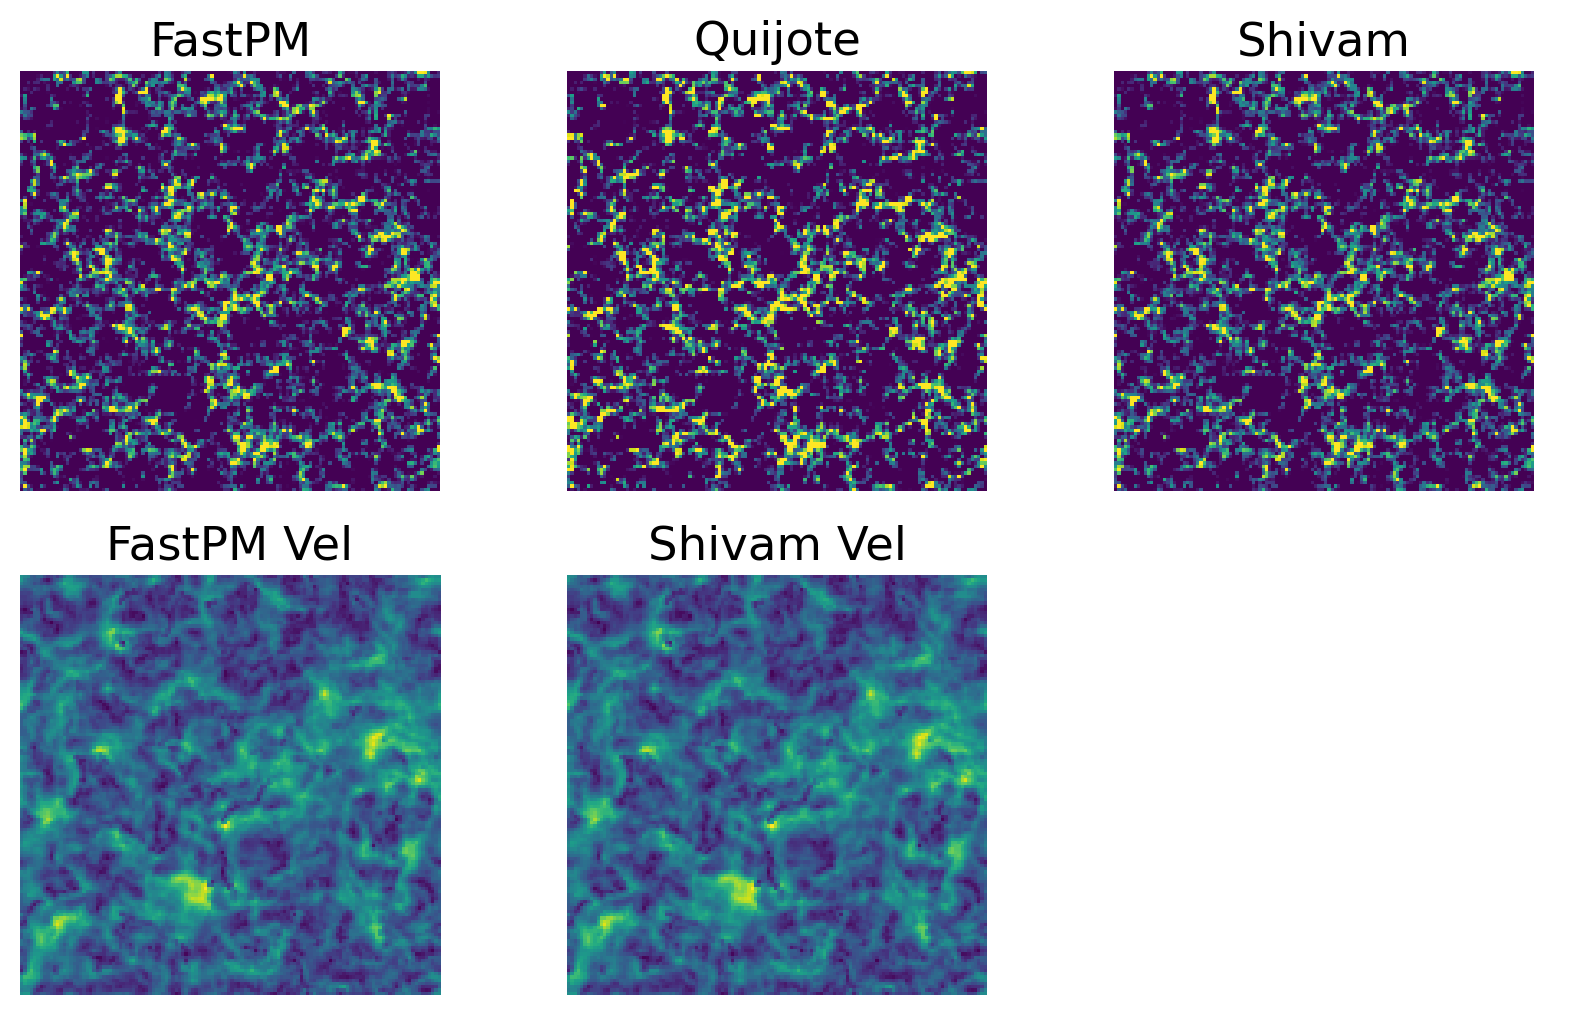

In [7]:
f, axs = plt.subplots(2, 3, figsize=(10, 6))
axs = axs.flatten()
axs[0].imshow(rhoc[50:60].sum(axis=0), vmin=-1, vmax=10)
axs[0].set_title('FastPM')
axs[1].imshow(rhoq[50:60].sum(axis=0), vmin=-1, vmax=10)
axs[1].set_title('Quijote')
axs[2].imshow(rhof[50:60].sum(axis=0), vmin=-1, vmax=10)
axs[2].set_title('Shivam')
axs[3].imshow(np.linalg.norm(fvelc[:,55], axis=0))
axs[3].set_title('FastPM Vel')
axs[4].imshow(np.linalg.norm(fvelf[:,55], axis=0))
axs[4].set_title('Shivam Vel')
for ax in axs:
    ax.axis('off')

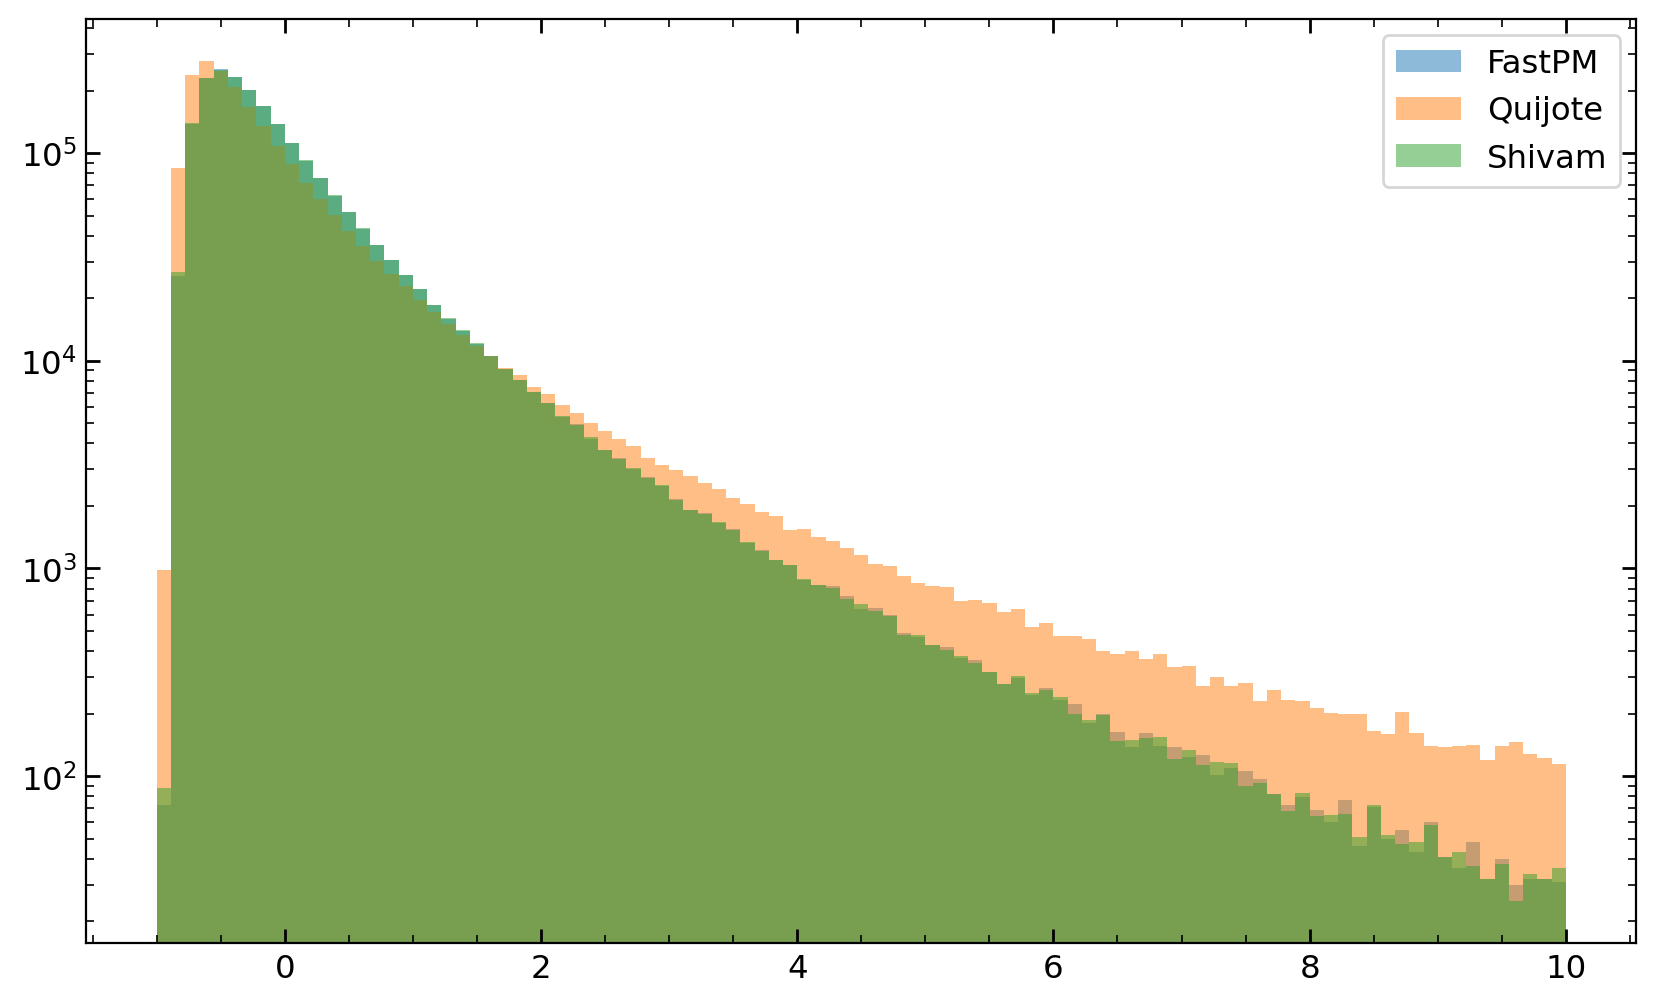

In [8]:
be = np.linspace(-1, 10, 100)
plt.semilogy()
plt.hist(rhoc.flatten(), bins=be, alpha=0.5, label='FastPM');
plt.hist(rhoq.flatten(), bins=be, alpha=0.5, label='Quijote');
plt.hist(rhof.flatten(), bins=be, alpha=0.5, label='Shivam');
plt.legend()

Text(0, 0.5, 'Quijote')

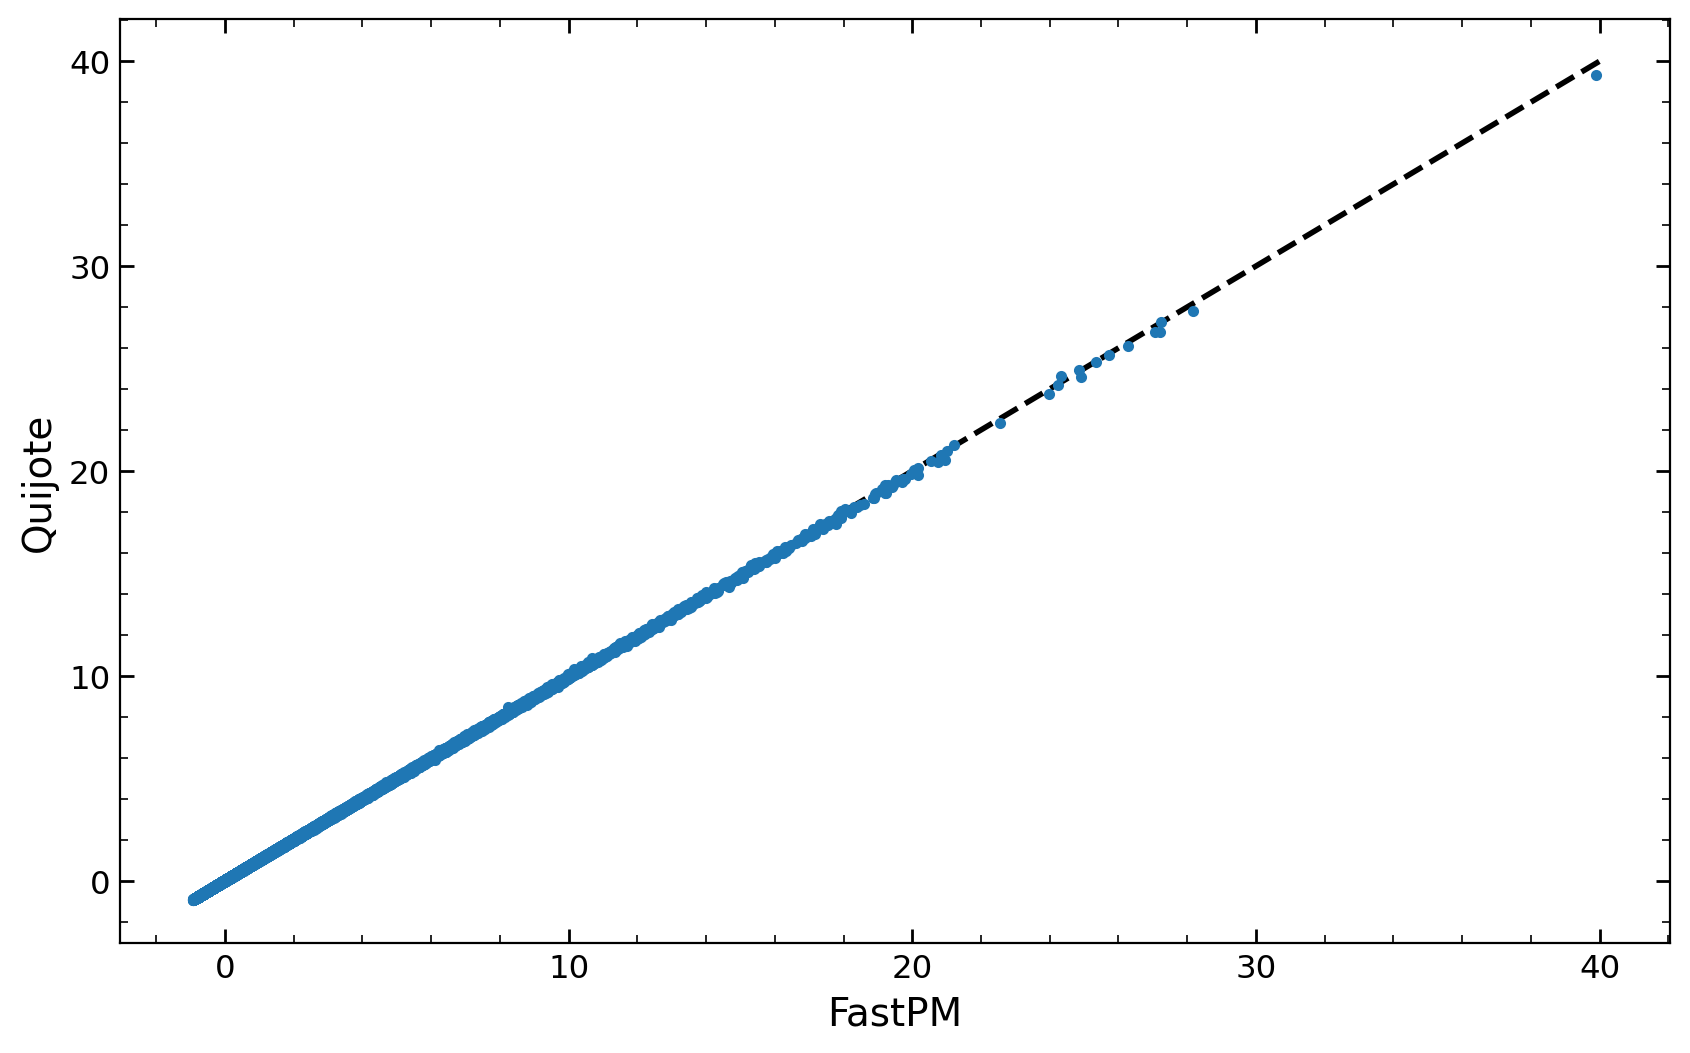

In [9]:
plt.plot([-1,40], [-1,40], 'k--')
plt.plot(rhoc.flatten(), rhof.flatten(), '.', alpha=1)
# plt.xlim(-1,6)
# plt.ylim(-1,6)
plt.xlabel('FastPM')
plt.ylabel('Quijote')

0.0063583907

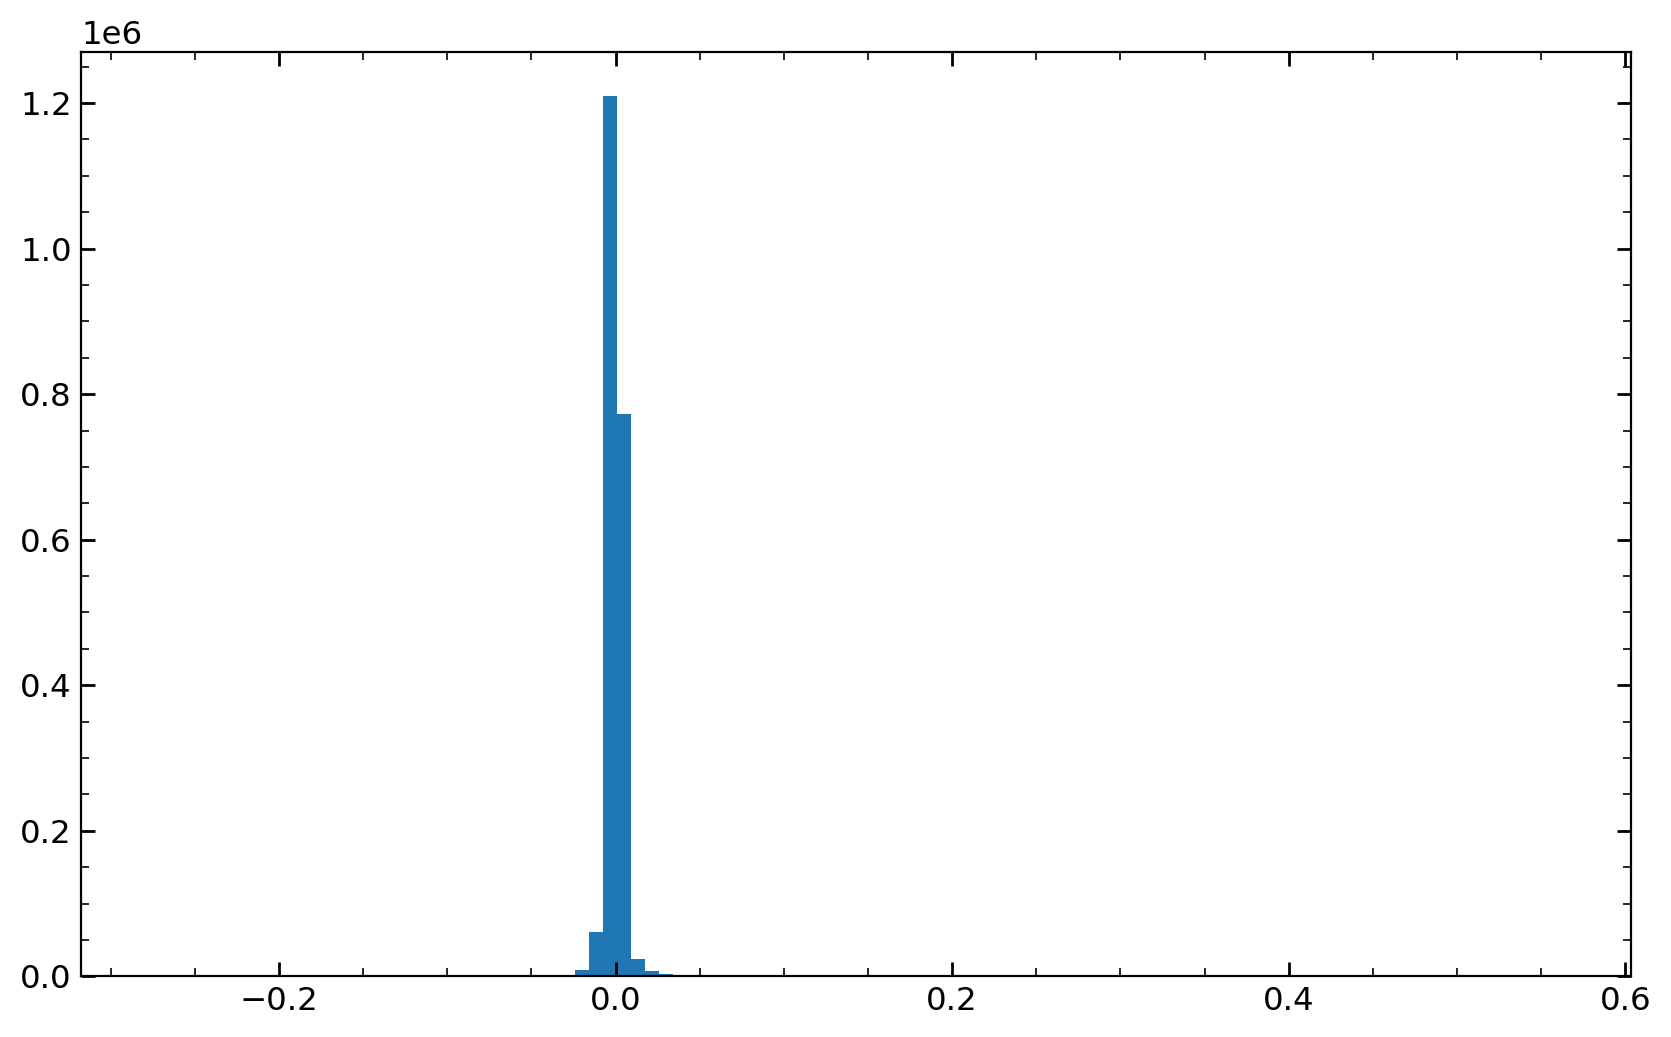

In [10]:
plt.hist(rhoc.flatten() - rhof.flatten(), 100);
np.std(rhoc.flatten() - rhof.flatten())/np.std(rhoc.flatten())

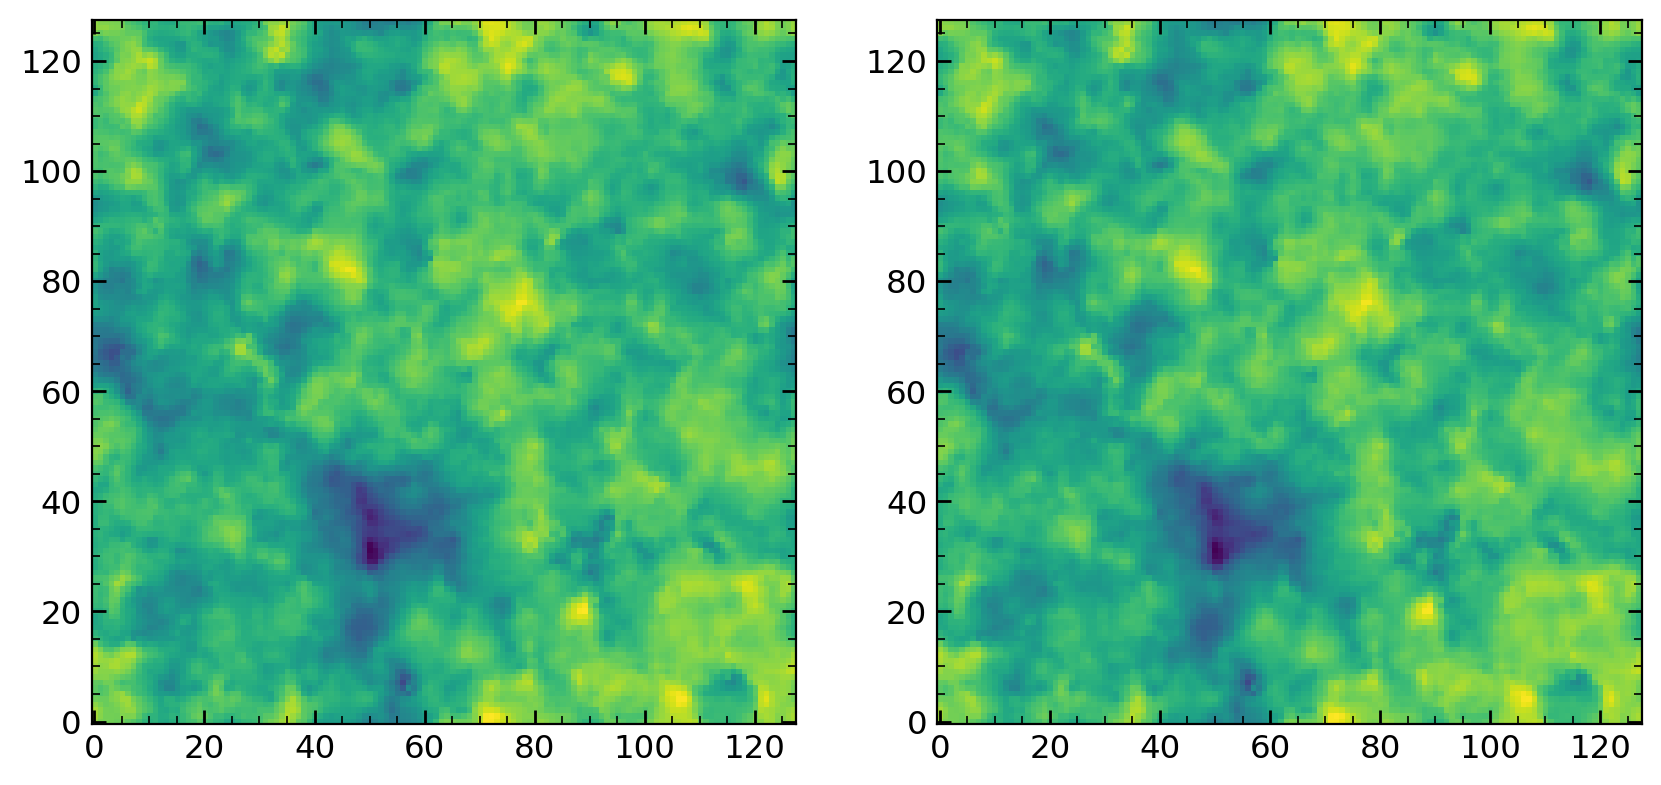

In [11]:
f, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(fvelc[0,0])
axs[1].imshow(fvelf[0,0])


Text(0, 0.5, 'Quijote')

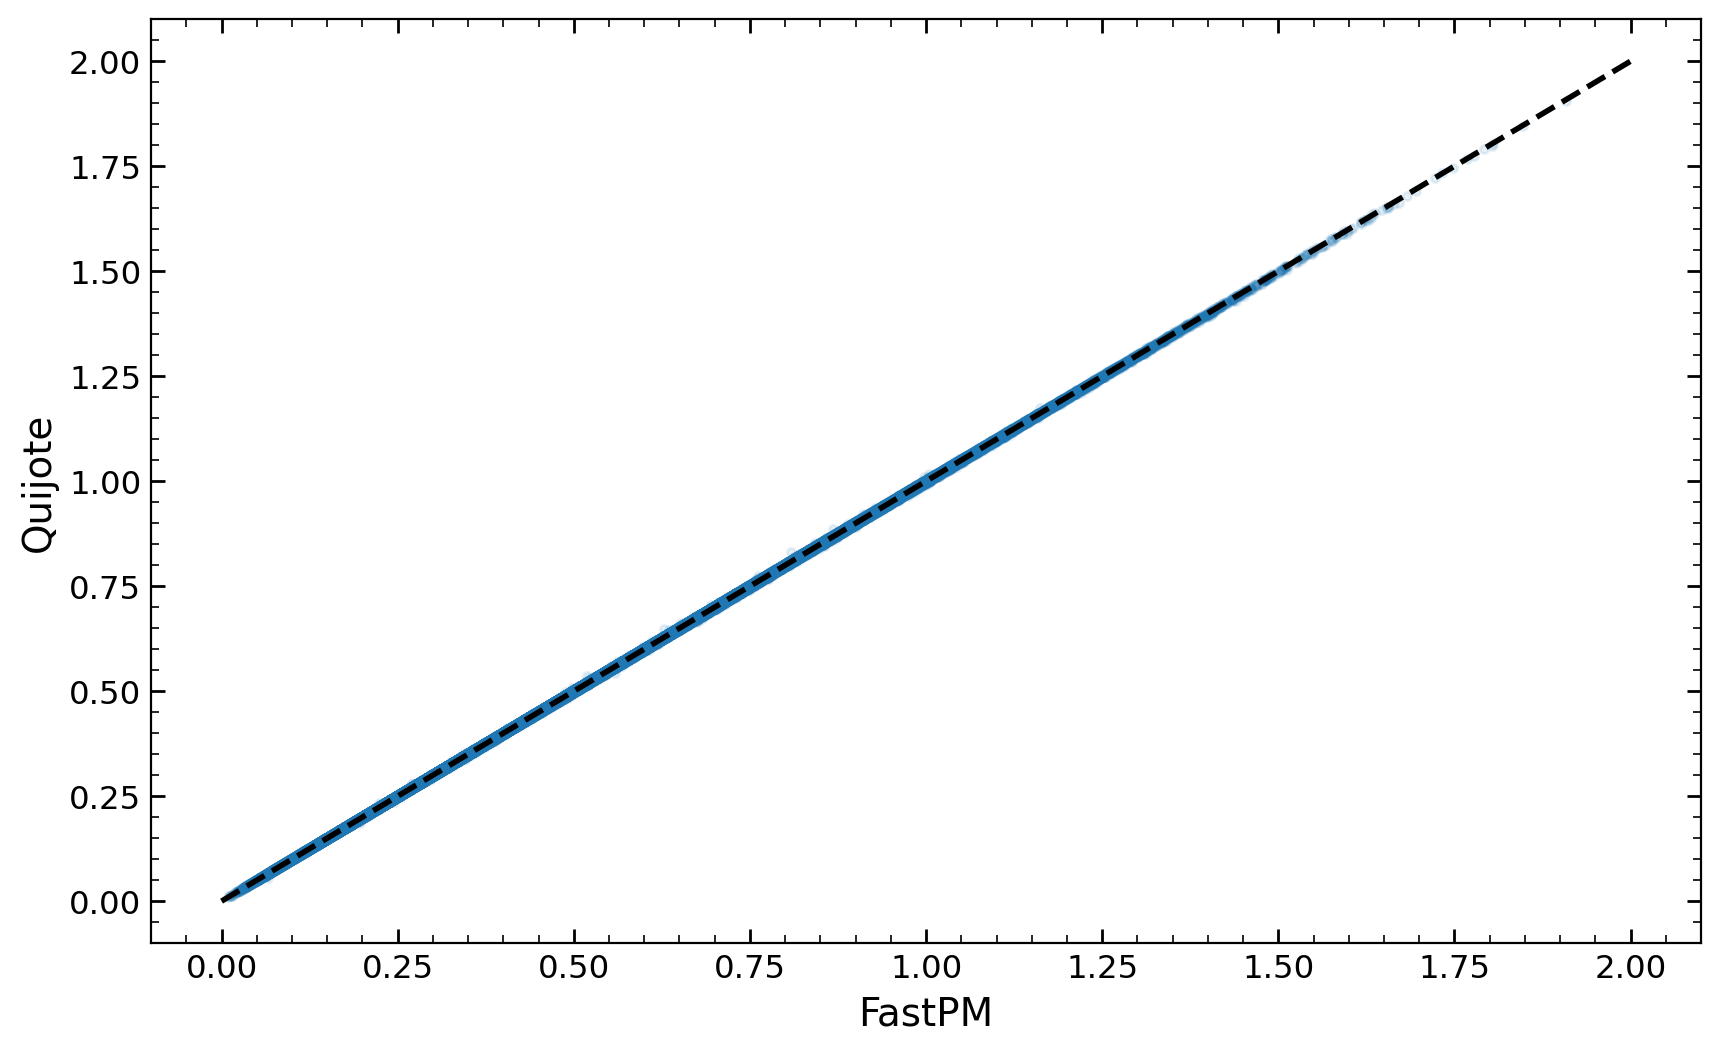

In [12]:
x_ = np.linalg.norm(fvelc, axis=0).flatten()[::10]/1e3/1.5
y_ = np.linalg.norm(fvelf, axis=0).flatten()[::10]
plt.figure()
plt.plot(x_, y_, '.', alpha=0.1)
plt.plot([0, 2], [0, 2], 'k--')
plt.xlabel('FastPM')
plt.ylabel('Quijote')

In [13]:
# look at halos

cdir = wdir+f'inf_1gpch/fastpm/L1000-N128/{lhid}'
with h5py.File(join(cdir, 'halos.h5'), 'r') as f:
    a = list(f.keys())[-1]
    print(f[a].keys())
    hpos = f[a]['pos'][...]
    hvel = f[a]['vel'][...]
    hmass = f[a]['mass'][...]

<KeysViewHDF5 ['mass', 'pos', 'vel']>


In [14]:
# Load Quijote

snapnum = lhid
isim_fid = lhid
mass_type = 'rockstar_200c'
snap_dir_base = '/anvil/scratch/x-mho1/quijote/Halos/Rockstar/latin_hypercube_HR'
snapdir = snap_dir_base + '/' + str(isim_fid)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]
if mass_type == 'rockstar_vir':
    index_M = header.index('Mvir')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
if mass_type == 'rockstar_200c':
    index_M = header.index('M200c')                    
    mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h


# Conform
qmass = np.log10(mass_truth)
mask = qmass > np.log10(5e12)
qmass = qmass[mask]
qpos = pos_h_truth[mask]
qvel = vel_h_truth[mask]

/tmp/ipykernel_3986306/2743529389.py:24: RuntimeWarning: divide by zero encountered in log10
  qmass = np.log10(mass_truth)


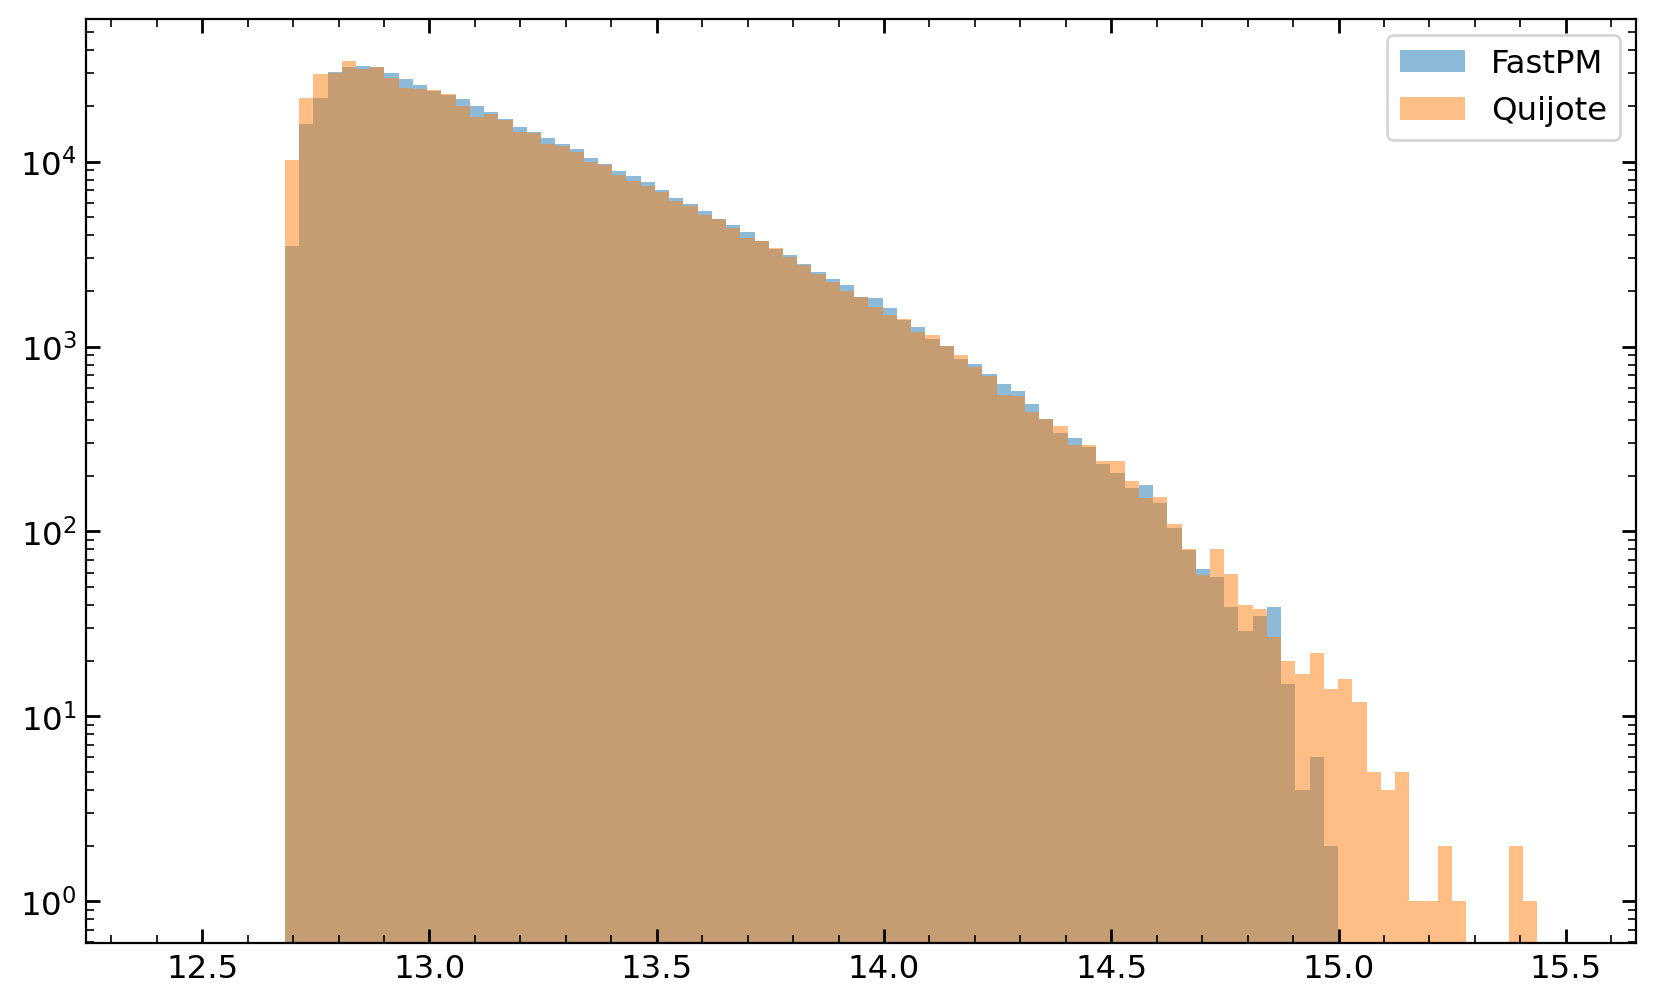

In [15]:
plt.semilogy()
be = np.linspace(12.4, 15.5, 100)
plt.hist(hmass, be, label='FastPM', alpha=0.5); 
plt.hist(qmass, be, label='Quijote', alpha=0.5);
plt.legend()

In [16]:
# REAL SPACE
import MAS_library as MASL
grid    = 128    #the 3D field will have grid x grid x grid voxels
BoxSize = 1000.0 #Mpc/h ; size of box
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress

# compute density field
hdelta = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(hpos.astype(np.float32), hdelta, BoxSize, MAS)

qdelta = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(qpos.astype(np.float32), qdelta, BoxSize, MAS)

# normalize
hdelta /= hdelta.mean()
qdelta /= qdelta.mean()
hdelta -= 1
qdelta -= 1

Text(0.5, 1.0, 'Quijote')

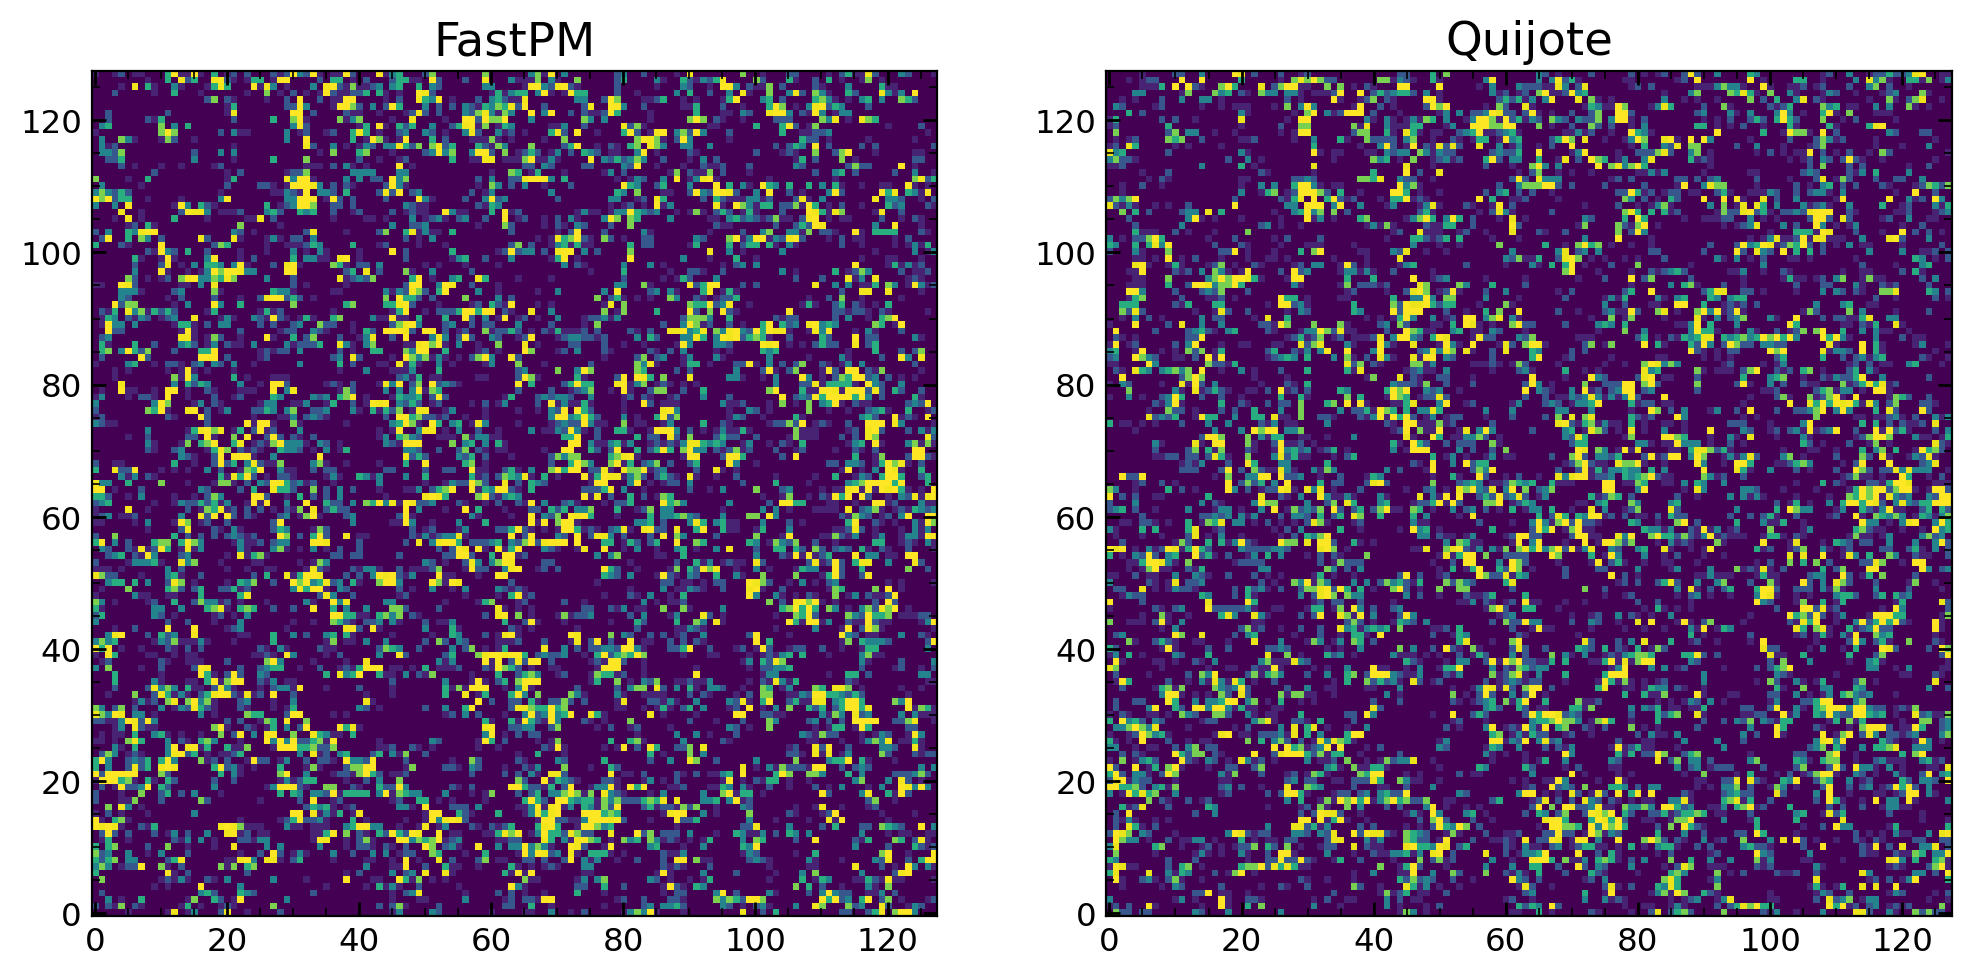

In [17]:
f, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(hdelta[50:60].sum(axis=0), vmin=-1, vmax=20)
axs[0].set_title('FastPM')
axs[1].imshow(qdelta[50:60].sum(axis=0), vmin=-1, vmax=20)
axs[1].set_title('Quijote')


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.07
Time taken = 0.09 seconds


Text(0.5, 1.0, 'Hexadecapole')

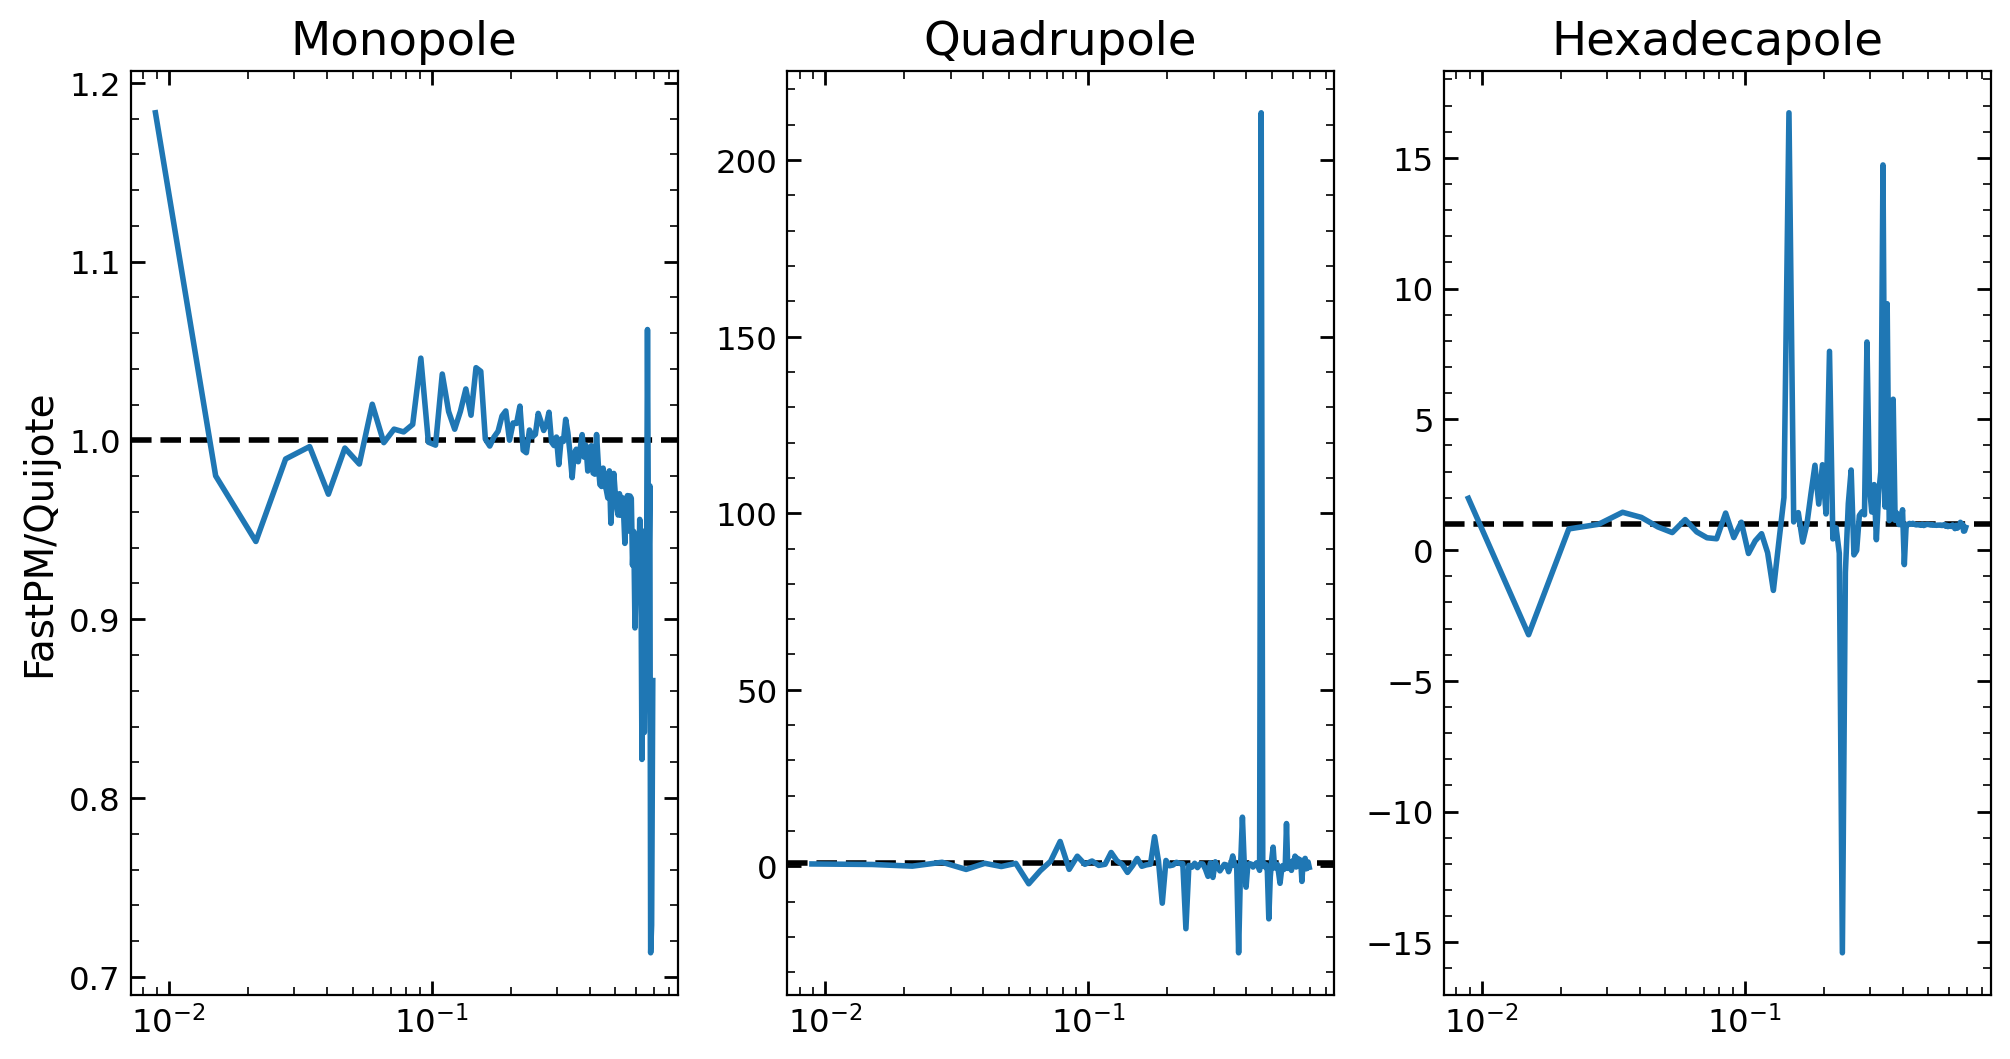

In [18]:
import Pk_library as PKL
Pk = PKL.XPk([hdelta, qdelta], BoxSize, axis=0, MAS='NGP', threads=1);
f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].axhline(1, color='k', ls='--')
axs[0].semilogx(Pk.k3D, Pk.Pk[:,0,0]/Pk.Pk[:,0,1], label='FastPM/Quijote')
axs[0].set_title('Monopole')
axs[0].set_ylabel('FastPM/Quijote')

axs[1].axhline(1, color='k', ls='--')
axs[1].semilogx(Pk.k3D, Pk.Pk[:,1,0]/Pk.Pk[:,1,1], label='FastPM/Quijote')
axs[1].set_title('Quadrupole')

axs[2].axhline(1, color='k', ls='--')
axs[2].semilogx(Pk.k3D, Pk.Pk[:,2,0]/Pk.Pk[:,2,1], label='FastPM/Quijote')
axs[2].set_title('Hexadecapole')

In [19]:
# REDSHIFT SPACE

import redshift_space_library as RSL
from copy import deepcopy
hposz = deepcopy(hpos).astype(np.float32)
qposz = deepcopy(qpos).astype(np.float32)
RSL.pos_redshift_space(hposz, hvel.astype(np.float32), 
                       BoxSize, 0.6313, 0.5, axis=0)
RSL.pos_redshift_space(qposz, qvel.astype(np.float32), 
                       BoxSize, 0.6313, 0.5, axis=0)

# compute density field
hdeltaz = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(hposz, hdeltaz, BoxSize, MAS)

qdeltaz = np.zeros((grid, grid, grid), dtype=np.float32)
MASL.MA(qposz, qdeltaz, BoxSize, MAS)

# normalize
hdeltaz /= hdeltaz.mean()
qdeltaz /= qdeltaz.mean()
hdeltaz -= 1
qdeltaz -= 1


Computing power spectra of the fields...
Time FFTS = 0.02
Time loop = 0.07
Time taken = 0.09 seconds


Text(0.5, 1.0, 'Hexadecapole')

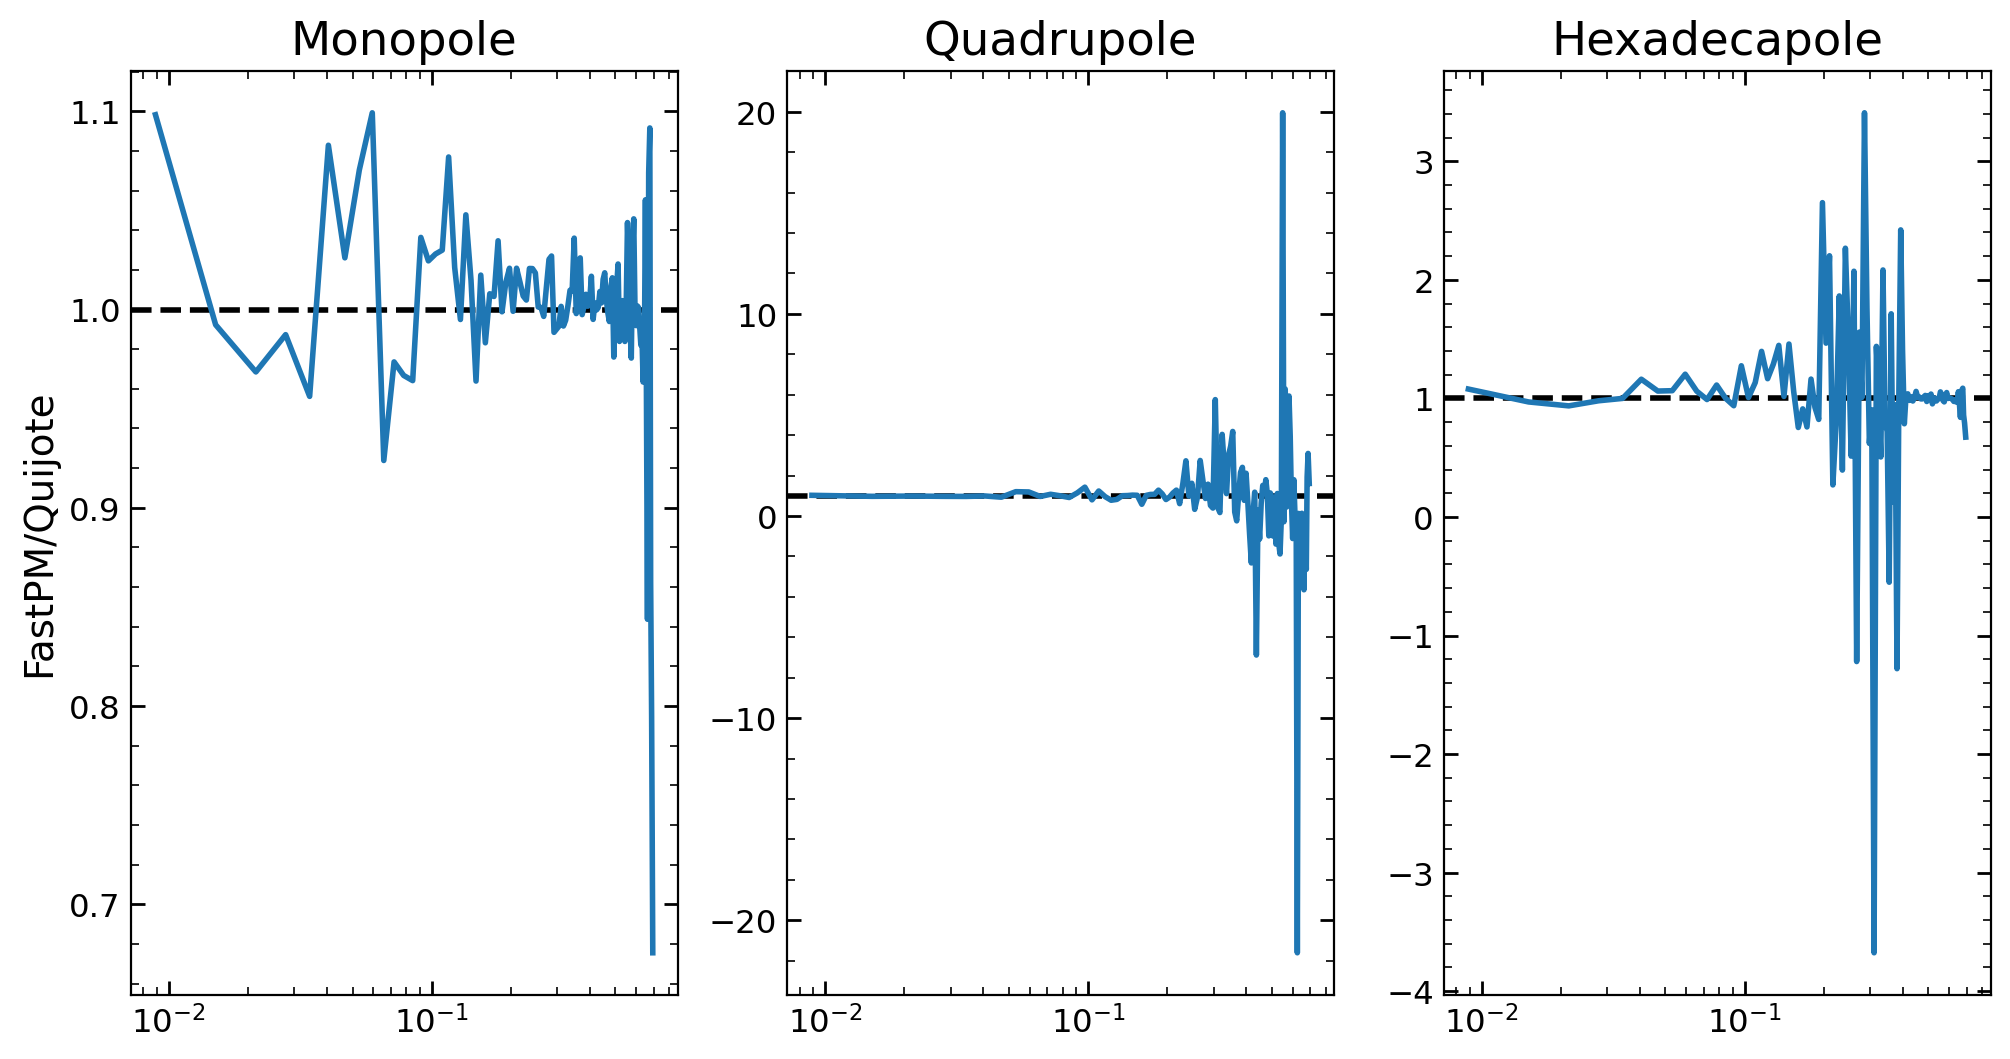

In [20]:
import Pk_library as PKL
Pk = PKL.XPk([hdeltaz, qdeltaz], BoxSize, axis=0, MAS='NGP', threads=1);
f, axs = plt.subplots(1, 3, figsize=(12, 6))
axs[0].axhline(1, color='k', ls='--')
axs[0].semilogx(Pk.k3D, Pk.Pk[:,0,0]/Pk.Pk[:,0,1], label='FastPM/Quijote')
axs[0].set_title('Monopole')
axs[0].set_ylabel('FastPM/Quijote')

axs[1].axhline(1, color='k', ls='--')
axs[1].semilogx(Pk.k3D, Pk.Pk[:,1,0]/Pk.Pk[:,1,1], label='FastPM/Quijote')
axs[1].set_title('Quadrupole')

axs[2].axhline(1, color='k', ls='--')
axs[2].semilogx(Pk.k3D, Pk.Pk[:,2,0]/Pk.Pk[:,2,1], label='FastPM/Quijote')
axs[2].set_title('Hexadecapole')